Создайте 1 нейронную сеть, в которой буду сразу все перечисленные слои: 2 CNN слоя с разными параметрами друг за другом, Пулинг слой после каждого CNN слоя, Дропаут в любом месте, GRU и LSTM (причем gru должен быть прямо- а lstm обратнонаправленным, а их последние стейты должны быть сконкатенированы). Обучитесь на тех же данных, что и на семинаре. Посчитайте качество и нарисуйте график. F-мера не должна быть ниже - 0.70

In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: lenta_sample.csv        
  inflating: __MACOSX/._lenta_sample.csv  


## UTILS

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## DATA

In [5]:
data = pd.read_csv('lenta_sample.csv')

In [6]:
data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2004/05/14/dress/,Жириновский придумал новую форму для женщин-де...,Вице-спикер Госдумы Владимир Жириновский высту...,Из жизни,Все,2004/05/14
1,https://lenta.ru/news/2002/01/08/orders/,Новый год для экономики Европы начинается с хо...,Европейский индекс предпринимательского и потр...,Экономика,Все,2002/01/08
2,https://lenta.ru/news/2010/10/14/dolgostroi/,"На достройку ""проблемных"" домов в СЗАО выделят...","Московские власти выделят ГУП ""Управление по р...",Дом,Все,2010/10/14
3,https://lenta.ru/news/2015/06/22/aircraftcarrier/,Строительство российского авианосца начнется п...,Строительство российского авианосца нового тип...,Силовые структуры,NaN,2015/06/22
4,https://lenta.ru/news/2013/09/18/sen/,Сенаторы США призвали наказать российские банк...,Сенатор Ричард Блументаль (Richard Blumenthal)...,Мир,Политика,2013/09/18


In [7]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))


filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)


word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [10]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [11]:
MAX_LEN

200

In [12]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [13]:
len(label2id)

19

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

## MODEL

In [29]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

# Conv layers
conv1 = tf.keras.layers.Conv1D(
    kernel_size=10, 
    filters=128, strides=10,
    name='Conv1')(embeddings)
conv2 = tf.keras.layers.Conv1D(
    kernel_size=5, 
    filters=128,
    strides=5,
    name='Conv2')(embeddings)
pool1 = tf.keras.layers.GlobalMaxPool1D(name="PoolConv1")(conv1)
pool2 = tf.keras.layers.GlobalMaxPool1D(name="PoolConv2")(conv2)
conv = tf.keras.layers.concatenate([pool1, pool2], name='Conv1_plus_Conv2')

# RNN layers
gru_forward = tf.keras.layers.GRU(128,
                                  return_sequences=False,
                                  name='GRU_forward')(embeddings)
lstm_backward =  tf.keras.layers.LSTM(128,
                                      return_sequences=False,
                                      go_backwards=True,
                                      name='LSTM_backward')(embeddings)

rnn = tf.keras.layers.concatenate([gru_forward, lstm_backward],
                                  name="GRU_plus_LSTM")

# merge rnn and conv
merged = tf.keras.layers.concatenate([conv, rnn], name='Conv_plus_RNN')
# dropout layer
merged = tf.keras.layers.Dropout(.1, name='Droupout')(merged)

dense = tf.keras.layers.Dense(64, activation='relu')(merged)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

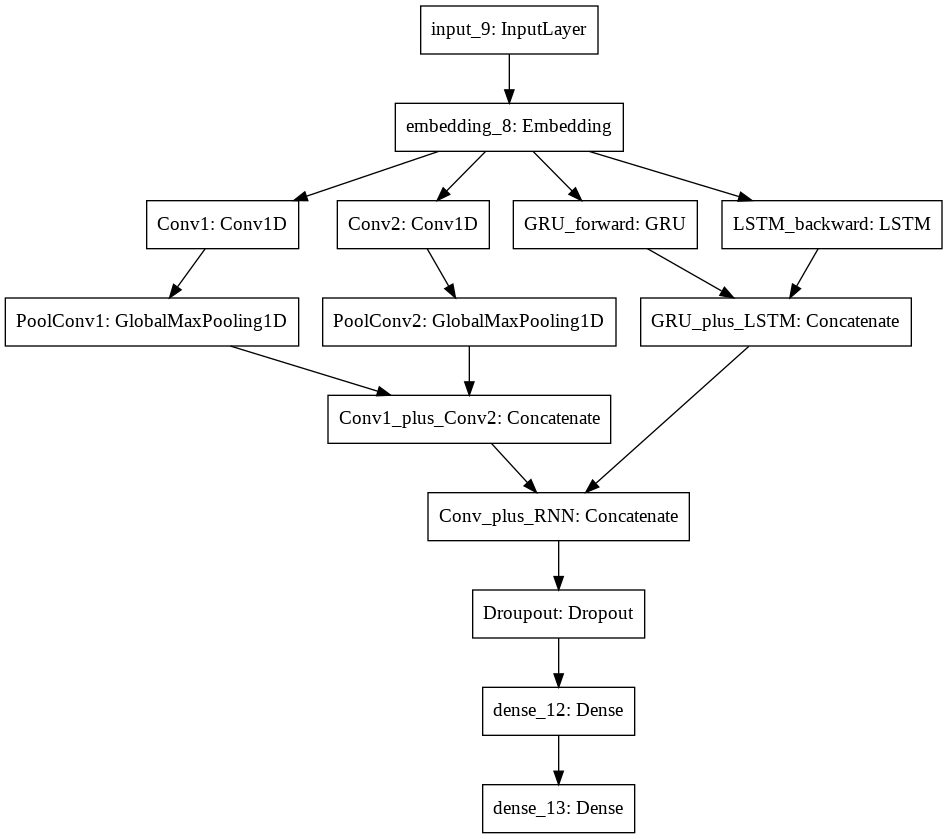

In [77]:
earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_f1", min_delta=0.0001, patience=5, verbose=1, mode="max"
    )

tf.keras.utils.plot_model(model)

## Train and evaluate

In [38]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=30,
          callbacks=[earlystopping])

Epoch 1/30
141/141 [==============================] - 47s 336ms/step - loss: 0.0970 - f1: 0.9757 - rec@prec: 0.9959 - val_loss: 1.1250 - val_f1: 0.7640 - val_rec@prec: 0.7347
Epoch 2/30
141/141 [==============================] - 47s 337ms/step - loss: 0.0496 - f1: 0.9898 - rec@prec: 0.9988 - val_loss: 1.2748 - val_f1: 0.7619 - val_rec@prec: 0.7279
Epoch 3/30
141/141 [==============================] - 47s 337ms/step - loss: 0.0247 - f1: 0.9958 - rec@prec: 0.9996 - val_loss: 1.4221 - val_f1: 0.7598 - val_rec@prec: 0.7241
Epoch 4/30
141/141 [==============================] - 47s 336ms/step - loss: 0.0144 - f1: 0.9978 - rec@prec: 0.9998 - val_loss: 1.5431 - val_f1: 0.7572 - val_rec@prec: 0.7210
Epoch 5/30
141/141 [==============================] - 47s 335ms/step - loss: 0.0095 - f1: 0.9986 - rec@prec: 0.9999 - val_loss: 1.6271 - val_f1: 0.7601 - val_rec@prec: 0.7233
Epoch 6/30
141/141 [==============================] - 47s 336ms/step - loss: 0.0074 - f1: 0.9989 - rec@prec: 0.9999 - val_los

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


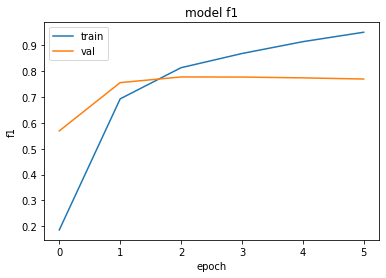

In [36]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
from sklearn.metrics import classification_report
pred = model.predict(X_valid)
print(
    classification_report(
        y_valid.argmax(1),
        pred.argmax(1),
        labels=range(len(label2id)),
        target_names=label2id,
        zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       0.76      0.78      0.77       536
           Бизнес       0.49      0.40      0.44        73
          Легпром       0.00      0.00      0.00         1
         Культура       0.84      0.85      0.84       532
         Из жизни       0.49      0.49      0.49       277
            Спорт       0.95      0.94      0.94       644
         Ценности       0.74      0.68      0.71        75
      Путешествия       0.55      0.55      0.55        66
   69-я параллель       0.27      0.23      0.25        13
              Дом       0.76      0.77      0.76       225
           Россия       0.77      0.76      0.77      1600
    Культпросвет        0.00      0.00      0.00         4
              Мир       0.75      0.77      0.76      1365
       Библиотека       0.00      0.00      0.00         0
             Крым       0.67      0.29      0.40         7
        Экономика       0.79      0.80      0.79       